In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from lightgbm import LGBMRegressor,plot_importance

import lightgbm as lgb
import xgboost

In [26]:
trainv2 = pd.read_csv('train_V2.csv')

In [3]:
trainv2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [4]:
trainv2.describe().columns

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'matchDuration', 'maxPlace', 'numGroups', 'rankPoints', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'winPlacePerc'],
      dtype='object')

In [5]:
trainv2.describe(include=['O']).columns

Index(['Id', 'groupId', 'matchId', 'matchType'], dtype='object')

In [6]:
##전투 데미지,킬(헤드샷) 어시스트 기절
##이동 걸은 거리 탑승 거리
##생존 치유/부스트 리바이스

In [7]:
##전투 damageDealt,kills(headshotKills),assists,DBNOs
##이동 walkDistance,rideDistance
##생존 heals/boosts revives

In [27]:
trainv2[trainv2.isnull().any(axis=1)]
trainv2 =trainv2.drop(index=2744604) #결측치 제거

In [28]:
cond=trainv2.matchType.isin(['squad-fpp','duo-fpp','squad','solo-fpp','duo','solo'])#캐쥬얼,사용자 지정 모드를 제외시킨다
trainv2 = trainv2[cond]

In [29]:
cond2 = trainv2['matchId'].value_counts().loc[trainv2['matchId'].value_counts()>60].index #한게임당 60명 이하 참여한 게임을 제외시킨다
trainv2 = trainv2.loc[trainv2['matchId'].isin(cond2)]

In [11]:
#ordinal encoding
# ordi = trainv2[['matchType']]
# ordinalencoder = OrdinalEncoder()
# raw_ordi = ordinalencoder.fit_transform(ordi)
# trainv2["matchtype"]=raw_ordi
# trainv2 =trainv2.drop(columns="matchType")

In [12]:
##데이터를 학습시킨다 지도 학습 x   (학습)   y 
##학습이 잘되게 하기 위해서 타겟값에 영향(상관계수,featureImpotance등)을 미치는 컬럼을 포함시킨다
##반대로 말하면 영향을 미치는 컬럼을 제외시키면 모델학습이 잘 안될수도 있다

##현업에서는 중요한 컬럼보다는 과정을 더 중요하게 여긴다 성능보다는 논리적으로 기준을 잡는다

##그룹아이디는 한매치당 같은 팀원을 표시해주는 데이터이지만 최대팀원 4이상의 데이터들이 있다
##df[df.groupby('groupId')['groupId'].transform('size')>4].sort_values(by='groupId') 726082 rows

#michaelapers님이 말하길 : 게임에서 연결이 끊기기 때문에 발생하는 현상입니다. 
#연결 해제가 발생하면 여러 그룹의 플레이어가 API의 데이터베이스에 동일한 최종 배치를 가진 것으로 저장되기 때문입니다.
#그렇기에 우리는 groupId를 확실히 함께한 팀이 아니라 동일한 최종 순위를 가진 선수라고 생각해야 합니다.

##데이터에는 솔로 듀오 스쿼드의 경기 기록이 포함되어 있으며 듀오 스쿼드의 경우
##팀원이 1명이라도 살아남아 등수가 높아지면 팀원 전부 같은 타겟값을 가지게 된다 
##위의 오류로 인해 등수가 실제로 낮아야 하지만 타겟값이 상향성을 가질수 있어 높은 등수로 기록되는 데이터가 존재하고
##실제로 정상적인 데이터의 경우도 팀원의 등수가 낮지만 다른 팀원의 그룹아이디 기준으로 같은 타겟값을 가지게 된다 
##오류와 실제 데이터를 구별할수 있는 구별점을 찾을수 없으며 따라서 수정할수도 없다 판단되어 진다
##df[df.matchId=='bac52627a12114'].sort_values(by='groupId',ascending=False).head(30)#95명

##오류인 데이터의 양이 많고 그룹아이디는 오류이지만 나머지 컬럼들의 값은 정상적이라 판단되어 삭제 할수도 없다
##수정도 삭제도 할수 없지만 타겟값이 고정되어 있기 때문에 전체적인 모델학습이 안될꺼라 판단되어 진다
##그룹아이디를 구별할수 있는 컬럼을 찾지 못했기에 임의로 그룹아이디값을 수정한다고 해도 타겟값을 변경할수 없기 때문에
##모델학습에 적합한 데이터셋이 아니라 생각되어 의욕이 많이 떨어진다('killPlace이후 연타')


##이어서 등수를 쉽게 올릴수 있는 스쿼드 듀오 솔로 기준으로 게임이 쉽다 생각 할수 있으며
##실제로 사람들이 어려운 게임보다 쉬운게임을 원하는 경향으로 게임수가 스쿼드 듀오 솔로 순으로 난이도에 대한 순서가 있고
##난이도가 쉬울수록 등수가 오를 가능성이 있기 때문에 matchType은 오디널 인코딩을 선택하였다

##실제로 배틀그라운드는 생존fps 게임으로 0킬로 우승한다는게 불가능한 게임은 아니지만
##데이터중 0킬이지만 등수와 승률이 높은 경향이 있는거 같아 솔로기준으로 데이터를 살펴보았다
##df[df.matchId=='01aead02bb8901'].sort_values(by='killPlace',ascending=False)

##위 경기는 솔로경기이며 최대인원이 100명 중 참여인원이 20명인 데이터이다
#그룹아이디는 2개로 5등부터 20등까지 1등에서 4등까지 그룹아이디가 2개로 나눠져있으며 편히 1등과 2등으로 지칭한다
#2등그룹은 무기획득을 최대18회 까지 한데이터가 있지만 walkDistance가 0이며 무기획득을 하려면 케릭터가 움직여야 하니
#이상 데이터라 생각이 되고
#전체적으로 데미지를 입혔지만 킬을 한 유저가 한명도 없으며 종합결과 정상적인 match가 아니라고 판단되어 진다
#df[(df.kills==0)&(df.winPlacePerc==1.0)].matchId.value_counts()#kills 이 0인데 승률이 1.0인 경우 13231
#듀오와 스쿼드의 데이터상 킬수가 0이여도 승률이 1.0이 될 가능성이 있으며 그럴수 없는 솔로의 경기만 따로 확인하였다

##솔로경기중 킬이 0이지만 승률이 1.0인 데이터가 938건이며 matchId기준 375건이다
#df[(df.kills==0)&(df.winPlacePerc==1.0)&(df.matchType=='solo')].loc[:,'matchId'].value_counts()#936건 matchId기준 375건

##킬이0이면서 승률이 1.0이 있는 경기이지만 정상적으로 보이는경우 (elo 시스템 때문인듯하다 이상치제거를 할수없다)
#df[df.matchId=='c608582a5a22d6'].sort_values(by='winPlacePerc',ascending=True).tail(20)

#수작업으로 모든 matchId를 확인하는 방법밖에 없는듯 하다
#matchId 기준 모든 kills 데이터가 0인 경기만 따로 뽑아내는 반복문을 돌려야되나...??
##지워야할 데이터는solo 에만 존재했다

##이후 60명 이하의 게임drop으로 인해 킬이 0으로 표시되던 경기들이 다 사라진것을 확인하였다


In [30]:
df = trainv2.copy()
ddf =trainv2.copy()

In [21]:
df.matchType.value_counts() #원래 데이터 
#squad-fpp    1756186
# duo-fpp       996691
# squad         626526
# solo-fpp      536761
# duo           313591
# solo          181943

#60명이하 제거시

# squad-fpp    1752557 (drop = 3629 rows)
# duo-fpp       992747 (drop = 3944 rows)
# squad         625265 (drop = 92196 rows)
# solo-fpp      534330 (drop = 2431 rows)
# duo           312331 (drop = 1260 rows)
# solo          173348 (drop = 8595 rows)

#for문을 이용해 제거시

#squad-fpp    1756186
# duo-fpp       996691
# squad         626526
# solo-fpp      536761
# duo           313591
# solo          175592 (drop =6351 rows)

5.0    1752557
1.0     992747
4.0     625265
3.0     534330
0.0     312331
2.0     173348
Name: matchtype, dtype: int64

In [ ]:
#60명 이하 제거시 조건에 걸리는 데이터가 전혀 없다 
!pip install tqdm

from tqdm import trange, notebook            # show progress-bar

matchList=df[(df.kills==0)&(df.winPlacePerc==1.0)&(df.matchType=='solo')].loc[:,'matchId'].value_counts().index.to_list()
checkList=[]
indexList=[]
for i in notebook.tqdm(matchList):
    check = df[df.matchId==i].kills>0
    if check.any() == False :
        checkList.append(i)
        indexList.append(df[(df.matchId==i)].index)
        drop=df[(df.matchId==i)].index
        df.drop(drop,axis='index',inplace=True)
    else:
        print('True :',i)

In [33]:
#많은 데이터가 drop 되었는데 jointplot 확인시 큰변화가 없는거 같아 matchId 기준 스쿼드 경기 형태는 분석해보았다
df[(df.matchType=='squad')&(df.kills==0)&(df.winPlacePerc==1.0)] #스쿼드의 경기중 킬이 0이면서 타겟값이 1.0인 데이터
df[df.matchId=='04832cfd74ff30'].sort_values(by=['winPlacePerc','groupId','killPlace'] ,ascending=[False,False,False]).iloc[:,[0,1,11,12,13,15]].head(20)

,Id,groupId,kills,killStreaks,longestKill,matchType
107,7970b4ea89e81e,abf9e2780b9f48,0,0,0.000,squad
3720448,d568970adc3634,abf9e2780b9f48,2,1,74.250,squad
4326988,b7d3d7925b4b98,abf9e2780b9f48,4,2,257.900,squad
1374686,349e410faab4b2,abf9e2780b9f48,6,3,207.100,squad
2674666,a1930d01aa8c35,ed8bca93e4691f,0,0,0.000,squad
516932,e0cf03760863a7,ed8bca93e4691f,0,0,0.000,squad
2581425,0fe108972bef77,ed8bca93e4691f,3,1,101.900,squad
742659,3fe8950d799c70,ed8bca93e4691f,3,3,41.220,squad
2271591,4b6dfa3e460f80,51f3a5a72d3a68,0,0,0.000,squad
479919,2ad3a0beba8fe2,51f3a5a72d3a68,2,1,23.840,squad


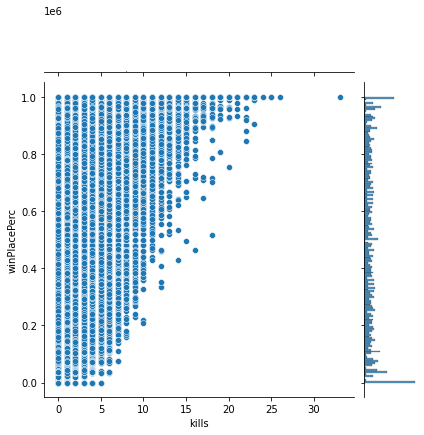

In [34]:
sns.jointplot(data=df,x='kills',y='winPlacePerc')
#kills컬럼과 타겟값의 그래프를 보고 적은 킬을 기록했지만 타겟값이 높은 데이터에 대해
#matchId 이상치 제거를 하려 했고 groupId 기준 팀원의 타겟값을 가질수 있기 때문에
#solo 모드에서 drop된 (60명이하 게임기준)이후 그래프를 보더라도
#크게 변화 된것이 없다 이상치라 판단되는것도 전부 제거했다고 생각한다 

<AxesSubplot:xlabel='kills', ylabel='winPlacePerc'>

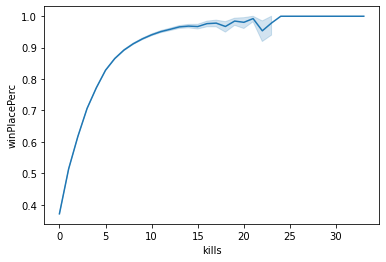

In [35]:
sns.lineplot(data=df,x='kills',y='winPlacePerc')
#kills수가 높아 질수록 타겟값이 커진것을 확인 20~25킬 사이 이상치인지 데이터 확인

<AxesSubplot:xlabel='headshotKills', ylabel='winPlacePerc'>

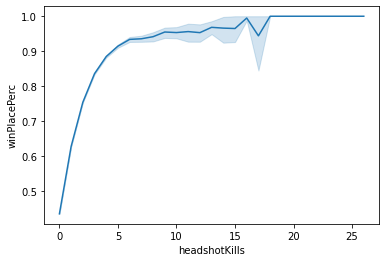

In [36]:
sns.lineplot(data=df,x='headshotKills',y='winPlacePerc')

In [38]:
df[(df.kills>20)&(df.kills<25)]
#정상적인 경기 데이터라 생각되며 이상치는 없어 보인다

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2569,7711e1d39407da,a9fbc63469296f,45fc89f9b11eaf,1,4,2325.0,13,8,2,1,...,1,2012.0,0,0.000,0,0,2697.0,5,1505,1.0000
37505,44513e16340a63,c1e3f56e09b9a4,cf5dd782577ea9,1,2,2767.0,24,17,1,1,...,0,2589.0,0,0.000,0,0,3290.0,7,1509,0.9615
118093,f9d14251d99ecf,c99533f640ece9,c8a16bfa406795,0,5,2267.0,0,14,3,1,...,0,2211.0,0,417.800,0,0,3324.0,4,0,0.9896
177466,1b7a2e34bb32af,d22356c38b0095,300e18813c5e78,0,12,2148.0,13,10,1,1,...,0,1674.0,0,16.140,0,0,4388.0,9,0,0.9787
397045,17b4206c8826c6,e792e3800fea6e,8a9a90c08db531,0,4,2719.0,17,5,2,1,...,3,6271.0,0,0.000,0,0,2423.0,5,1500,1.0000
731653,01c111bb670948,38eea7c94e6565,2a9abbff6f612e,0,4,2054.0,12,10,3,1,...,1,598.6,0,0.000,0,0,3840.0,3,0,1.0000
762460,77e319f2f462ea,020679422766b9,11c62cb0033ef7,0,9,1985.0,14,5,8,1,...,0,1648.0,0,0.000,0,0,3081.0,13,0,0.9286
785697,f791320d9bba06,8bfc503ec87808,95198bf5127411,5,8,1637.0,14,4,8,1,...,2,4506.0,0,0.000,0,1,2247.0,5,0,0.9200
979479,8e9eb1ce0e0135,d6c25ac6cbe0d4,8889fcc108e51e,0,7,2067.0,0,19,2,1,...,0,808.1,0,0.000,0,0,3507.0,4,0,1.0000
1064584,cfcd7492d003ab,4e3bda390a6339,cae8f5fab2e88e,1,4,2321.0,0,7,0,1,...,0,0.0,0,0.000,0,0,3028.0,5,1500,1.0000


In [39]:
df[(df.headshotKills>15)&(df.headshotKills<20)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
37505,44513e16340a63,c1e3f56e09b9a4,cf5dd782577ea9,1,2,2767.0,24,17,1,1,...,0,2589.0000,0,0.0,0,0,3290.0,7,1509,0.9615
63225,e31a1e0500c5b0,0fe2e6028c2b99,2cad837c3e6d46,1,6,1723.0,15,17,5,1,...,2,919.1000,0,122.3,0,0,3114.0,6,1570,1.0000
418426,07fe3b58dbaae0,14b8ef5a9edc61,c9c1afa5588cbe,1,6,2090.0,10,16,3,1,...,3,3678.0000,0,0.0,0,0,3221.0,4,1537,1.0000
539354,777a59f7dceb9c,1be852f783b980,d89c28b6a06ec5,0,0,1800.0,0,17,7,1,...,0,0.0138,0,0.0,0,0,1117.0,3,1503,0.7024
791364,4f35fdfa1fa840,14c44c8c414497,6f8d50c2481f73,0,5,2115.0,0,16,0,1,...,0,0.0000,0,0.0,0,0,3638.0,6,1549,0.9896
885426,bccc10b09592d7,6f6b40b378f39e,3158a006cdecab,1,12,2029.0,20,18,3,1,...,1,289.9000,0,0.0,0,0,2904.0,3,1536,1.0000
979479,8e9eb1ce0e0135,d6c25ac6cbe0d4,8889fcc108e51e,0,7,2067.0,0,19,2,1,...,0,808.1000,0,0.0,0,0,3507.0,4,0,1.0000
1699036,25ec950ff8e179,f6170ab22a7b34,95ebe0c3506179,2,7,2583.0,22,17,4,1,...,2,2382.0000,0,0.0,0,1,3726.0,6,1508,1.0000
1744909,daaf14f76f0398,067027699c7d7d,aa4ee3afac1f23,0,3,1883.0,10,17,4,1,...,0,0.0000,0,0.0,0,0,4298.0,9,1512,1.0000
1834930,125775b6f081e8,5293bbd6d0a7d3,4975b53ca28569,0,4,2778.0,18,17,2,1,...,0,1754.0000,1,0.0,0,0,2360.0,5,1568,1.0000


In [40]:
df[(df.kills == df.headshotKills)&(df.kills>10)]
#kills와headshotKills의 비율에 따라 모델학습시 두 컬럼을 합쳐서 사용할수 있는 방향을 생각해본다

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
346124,044d18fc42fc75,fc1dbc2df6a887,628107d4c41084,3,5,1620.0,13,11,3,1,...,3,4720.0,0,0.0,0,0,3422.0,8,1560,1.0000
871244,e668a25f5488e3,5ba8feabfb2a23,f6e6581e03ba4f,0,4,1365.0,9,13,0,1,...,0,0.0,0,0.0,0,0,2105.0,5,1587,1.0000
1079403,1c245ed99b5f96,e42d09a9b8463a,5cec236bce68eb,0,5,1218.0,8,11,3,1,...,0,5246.0,0,0.0,0,0,2932.0,4,0,1.0000
1348164,474a641f0a4bcb,2fdad3ca6fb3c0,114499c82f35d7,1,5,1319.0,11,12,1,1,...,0,2048.0,0,0.0,0,0,3915.0,5,0,1.0000
1380385,202ce6a55119c5,2df66861f597b4,496700c29a5d44,1,4,1150.0,4,11,1,1,...,1,0.0,0,0.0,0,0,3108.0,7,1500,1.0000
1483199,9d483f7cbb34d4,db5867bc814191,69495e3c478eb9,0,10,1478.0,8,13,2,1,...,0,0.0,0,140.8,0,0,2339.0,4,0,1.0000
1581850,6a5669a4c9dbed,a68b5edbdffc7b,aefc7da61179cb,0,3,1278.0,8,11,4,1,...,0,0.0,0,0.0,0,0,4715.0,5,0,1.0000
1753322,74e268b6d4870b,53bfcb6d8229f6,36579d5c2e52bc,0,7,1503.0,0,15,2,1,...,0,2018.0,0,0.0,0,0,2990.0,7,0,1.0000
2256755,d8474df8d8283a,50c8a5b906d89d,c6da477a07f4aa,0,7,1569.0,0,14,0,1,...,0,2785.0,0,0.0,0,0,2209.0,3,0,1.0000
2375749,48bd6fdf8719a4,d8a6b7a95481d8,360caa30aabd16,0,8,1290.0,0,14,1,1,...,0,561.4,0,0.0,0,0,2432.0,7,1500,0.9897


<AxesSubplot:xlabel='killStreaks', ylabel='winPlacePerc'>

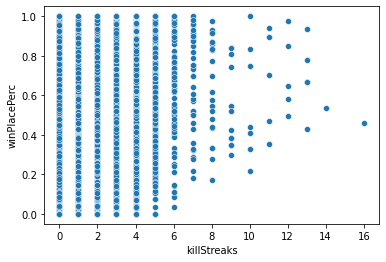

In [41]:
#가정 : 연속킬의 경우 주로 초반에 많이 이루어 지며 
#(같은장소에 많은 사람이 밀집되고 긴박하게 전투가 치루어져야 생기는 데이터인데 후반부로 갈수록 인원수가 줄어들며 
#넓은 맵에 사람들이 흩어져 있기 때문에 연속킬은 초반부 사람이 밀집되어 있어야 생기는 데이터라고 한정지을수 있다)
#연속킬이 있다거나 많다는것은 전투에서 죽을 확률이 그만큼 높아 지는것이므로 -조건에 해당한다 해도 된다고 판단되어 진다
sns.scatterplot(data=trainv2,x='killStreaks',y='winPlacePerc')
#그래프를 보았을때 연속킬이 높다고 해서 타켓값이 높다고 보여지지 않는다 위에 가정대로
#킬수에대한 타겟값에 변화가 있겠지만 -요소도 작용하고 있는걸로 보여져 타겟값 예측에 중요 지표로 보이진 않는다

<AxesSubplot:xlabel='longestKill', ylabel='winPlacePerc'>

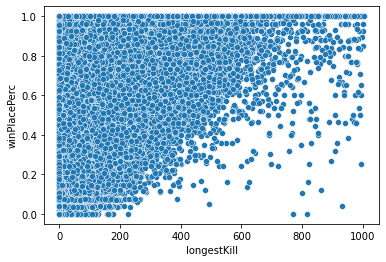

In [42]:
#가정 : 장거리킬의 경우 기록을 위한 데이터라 생각이 되어지며 컬럼설명에 기절시킨후 차량이동을 해도 거리가 기록 되기때문에 
#어떻게 보면 생존시간과 상관이 있어 보였지만 분포도를 확인해본 결과 이상치라 판단되어지는 데이터들이 많은것 같고 킬수가 적건
#킬수가 많건 최고 기록 1개만 나태내주고 데이터의 양도 188만으로 적은걸로 보인다

sns.scatterplot(data=trainv2,x='longestKill',y='winPlacePerc')

In [43]:
trainv2[(trainv2.kills>0)&(trainv2.longestKill>0)].loc[:,['kills','longestKill','winPlacePerc']].sort_values(by='longestKill',ascending=False)

,kills,longestKill,winPlacePerc
2981715,6,1003.0000,1.0000
202281,4,1000.0000,0.9231
195021,4,999.9000,0.8485
2888923,5,999.6000,0.9583
2216805,7,998.7000,1.0000
...,...,...,...
4032795,1,0.0661,0.9388
371411,1,0.0641,0.3750
3341076,1,0.0569,0.1702
3099262,1,0.0232,0.5104


In [44]:
#팀킬의 경우도 7만8천의 데이터로 중요지표로 보긴 힘들거라 판단되어 진다
trainv2[(trainv2.teamKills>0)&(trainv2.revives<trainv2.teamKills)]
#팀킬이 0이상인조건 + 팀원을 살린횟수보다 팀킬을 많이 한 데이터

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
32,e050d1f179d289,9e9fc09bcdab3f,bf3065e01dd3f9,0,3,0.0,0,0,1,61,...,0,1154.0,0,0.0,1,0,1240.0,7,0,0.5000
72,84aa77226db78f,90408966a87241,5b8ab02610ca96,0,3,0.0,0,0,13,49,...,0,0.0,0,0.0,1,0,3165.0,7,0,0.9655
150,528c5d3fde5198,a69d29530369ee,75a3ed5107269f,0,0,0.0,1,0,0,84,...,0,0.0,0,0.0,1,0,22.6,0,0,0.1071
199,faa4a171d344ec,ede32cd7e90217,0d48e3e0ab5ffa,0,0,349.2,3,0,0,4,...,0,0.0,0,0.0,1,0,3205.0,7,0,0.9259
329,ee02df189f18de,25dadec45e007c,f1f1f4ef412d7e,0,4,121.2,1,1,3,27,...,0,0.0,0,0.0,1,0,2339.0,5,0,0.7667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446728,5dccf955184ad1,1adc8fae0d1d0d,dc4037c011626a,0,4,0.0,0,0,10,51,...,0,0.0,0,0.0,1,0,3495.0,5,0,0.7857
4446785,e99ff8b262b674,ba3f61ef8ce4df,0f438470f9eb89,0,0,0.0,0,0,2,40,...,0,451.4,0,0.0,1,0,4262.0,7,0,0.8148
4446790,5af72128847c8b,5692a94aec2f11,cbc3665d093dbc,0,2,128.5,0,0,3,27,...,0,8484.0,0,0.0,1,2,1468.0,4,0,0.7526
4446917,7779efadcbdf62,44894111e2a72f,ffb988d7f98e87,0,2,189.7,1,0,1,23,...,0,0.0,0,0.0,1,0,3268.0,12,0,0.6429


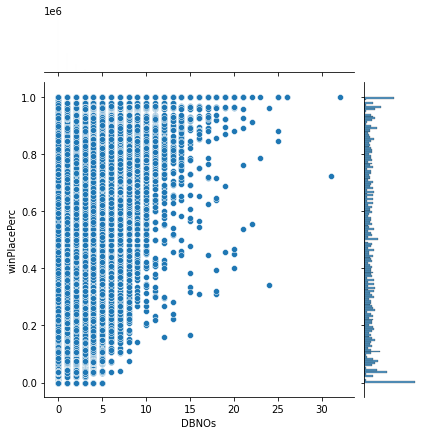

In [45]:
#적기절 값은 적을 마주한 경우가 많이 오히려 등수에 안좋은 영향을 가질꺼라 생각했지만
#연속킬과 다르게 싸움에 유리한 상황을 가지고 전투를 하는거라 생각되어 등수에 영향을 주는 지표라고 생각되어진다 
sns.jointplot(data=df,x='DBNOs',y='winPlacePerc')


In [46]:
df[df.DBNOs>10].sort_values(by='winPlacePerc')


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2887255,41c85f0370b3dd,30840a1f4a5a18,5f48fae9849f6a,0,1,1086.0,12,3,0,4,...,1,0.0,0,0.0,0,0,737.70,2,1500,0.1600
1481186,6a000ffd995657,296d00ec2d098c,3bd8f133f44e71,0,0,227.6,15,0,0,75,...,15,0.0,0,0.0,0,0,145.60,0,1460,0.1667
2967486,1e6ed2356ef311,887ce68ed1ac58,c357434ddb3850,0,0,200.0,11,0,0,79,...,11,0.0,0,0.0,0,0,10.55,0,1471,0.2174
1188131,066291fa113c31,9dd652b530611e,8de6eee95b535d,0,0,0.0,13,0,0,75,...,12,0.0,0,0.0,1,0,243.70,2,0,0.2222
175497,99879be398c871,0ea5fd23d4cc12,078c4e8c37bd00,0,0,0.0,11,0,0,66,...,10,1980.0,0,0.0,2,0,334.10,4,0,0.2333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2905385,8fb5cd2f5e49c4,af13fc7c7e4a3e,8be736409e2dc3,1,0,1580.0,12,9,2,1,...,0,6281.0,0,0.0,0,0,3006.00,3,0,1.0000
2905772,9953eb8ce600d7,50c27d2b6d6626,049b70aba0010e,3,4,765.3,11,0,1,1,...,0,5528.0,0,0.0,0,0,2166.00,6,1812,1.0000
1306578,18d5b38c8e1c27,5f8ed48b0a8162,ddaa06329b4456,3,4,2422.0,16,11,3,1,...,1,2257.0,0,0.0,0,0,2820.00,6,0,1.0000
2887901,2cca5d5beca680,7c7e4b4a73a33d,04613ee29cb842,2,8,1532.0,12,5,9,2,...,1,0.0,0,0.0,0,0,3529.00,3,1608,1.0000


In [47]:
df[(df.matchId=='5f48fae9849f6a')&(df.groupId=='30840a1f4a5a18')].sort_values(by='DBNOs')
#이상치라 판단되어지는 데이터인데 point계열의 컬럼들과 같이 써보고 학습효과가 좋지 않으면 drop 시키는방향으로 해야겟다

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2887255,41c85f0370b3dd,30840a1f4a5a18,5f48fae9849f6a,0,1,1086.0,12,3,0,4,...,1,0.0,0,0.0,0,0,737.7,2,1500,0.16


In [ ]:
#걸은거리는 물리적인 시간을 포함하고 있어 걸은거리가 크다는것은 살아있다는 지표 이므로 등수가 높을수있다 판단 
#차량이동은 짧은시간에 높은 이동거리를 얻을수 있어 + 한다면 스캐일러를 생각해보면 좋을거 같다 
#수영거리는 특성상 불리한경우이며 생존과 거리가 멀어 제외한다
trainv2.loc[:,['walkDistance','rideDistance','swimDistance','winPlacePerc']].plot.scatter(x='walkDistance',y='winPlacePerc')
trainv2.loc[:,['walkDistance','rideDistance','swimDistance','winPlacePerc']].plot.scatter(x='rideDistance',y='winPlacePerc')
trainv2.loc[:,['walkDistance','rideDistance','swimDistance','winPlacePerc']].plot.scatter(x='swimDistance',y='winPlacePerc')

In [48]:
df[(df.walkDistance==0)&(df.winPlacePerc==1.0)]
#걸은 거리가 없지만 타겟값이 1.0인데이터 killPlace가 낮아 초반에 죽었을 가능성을 확인 matchId기준 groupId가 1이라면 이상치라판단

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
120666,343a30631b578f,c22faceb6ffcb0,41149896fad0e6,0,0,0.0,0,0,0,50,...,0,0.0,0,3.3120,0,0,0.0,0,1502,1.0
461500,8c2e94f8d2a884,8a5f52e4900a65,70904f5adc1c3a,0,0,0.0,0,0,0,40,...,0,0.0,0,0.0000,0,0,0.0,0,0,1.0
519969,7f50eaf7acb49c,d480eb5d89e917,249f111aedbfd5,0,0,0.0,0,0,0,39,...,0,0.0,0,0.0000,0,0,0.0,0,1537,1.0
1190582,52b2b122d60f27,e02bb1f321b66b,1dc8636e624f7a,0,0,0.0,0,0,0,44,...,0,0.0,0,0.0000,0,0,0.0,0,1448,1.0
1407072,c2b6e98b181cc0,e4176269d13f5b,32c6cb6c522cec,0,0,0.0,0,0,0,35,...,0,0.0,0,0.0000,0,0,0.0,1,1540,1.0
1415433,13ccae63b5d101,7c076662510829,39f1817eeba27e,0,0,0.0,0,0,0,42,...,0,0.0,0,0.0000,0,0,0.0,1,1530,1.0
2303213,7662862e9c446b,ad45478a184bb7,45932cf2afd564,0,0,0.0,0,0,0,43,...,0,0.0,0,0.0003,0,0,0.0,0,1491,1.0
2327852,6fbef8fbf8769d,6f31d024084af1,125feb87f05a28,0,0,0.0,0,0,0,47,...,0,0.0,0,0.0000,0,0,0.0,0,0,1.0
2478102,22ad5d12743f39,395f7012f5e9b2,d6781b45f02c07,0,0,0.0,0,0,0,43,...,0,0.0,0,0.0916,0,0,0.0,0,1564,1.0
3112272,f6b67db4d49e95,06b0d7ed9fdba7,88c970445d38bf,0,0,0.0,0,0,0,36,...,0,0.0,0,4.3600,0,0,0.0,0,1484,1.0


In [49]:
df[(df.walkDistance==0)&(df.winPlacePerc==1.0)].loc[:,['groupId','matchId']]

,groupId,matchId
120666,c22faceb6ffcb0,41149896fad0e6
461500,8a5f52e4900a65,70904f5adc1c3a
519969,d480eb5d89e917,249f111aedbfd5
1190582,e02bb1f321b66b,1dc8636e624f7a
1407072,e4176269d13f5b,32c6cb6c522cec
1415433,7c076662510829,39f1817eeba27e
2303213,ad45478a184bb7,45932cf2afd564
2327852,6f31d024084af1,125feb87f05a28
2478102,395f7012f5e9b2,d6781b45f02c07
3112272,06b0d7ed9fdba7,88c970445d38bf


In [ ]:
df[(df.matchId=='8024c2c67ea10f')&(df.groupId=='365ebcc57a8de7')].winPlacePerc.count()
#데이터가 적어 수동으로 이상치 판단을 해본결과 이상치는 없다고 생각

In [ ]:
#무기획득의 경우 보통 2~5사이의 값이 있을것이며 총을 줍지 못하고 죽는경우 0
#차이가 나는 데이터를 가지고 있지만 무기를 많이 줍는다고 생존율이 높아지는것은 아니기때문에 
#이상치 제거를 하거나 drop해야할것 같다
sns.jointplot(data=df,x='weaponsAcquired',y='winPlacePerc')

In [50]:
df[df.weaponsAcquired>50]# 무기획득 50개 이상한 데이터

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
185056,009d57d25f387f,d433eda5ca10d8,8842de7d656889,0,2,388.40,2,1,3,6,...,1,0.0,0,0.00,1,0,2482.0,67,0,0.9259
233643,7c8c83f5f97d0f,b33b210a52a2f8,2e8a0917a71c43,0,0,67.11,0,0,0,44,...,0,1880.0,0,0.00,0,0,1307.0,128,1577,0.7111
422018,79497b3ad02a5e,64ec3f1e594f01,fa085380974299,0,4,184.50,1,0,1,28,...,0,2546.0,0,0.00,0,0,1720.0,70,0,0.9792
464124,2e36b7589a065a,667b7c652802e1,53a2310a35a149,1,1,48.83,0,0,1,49,...,0,7036.0,0,0.00,0,0,1764.0,63,0,0.6304
588387,c58e3e0c2ba678,3d3e6100c07ff0,d04dbb98249f76,0,1,175.30,1,0,2,48,...,0,0.0,0,0.00,0,0,1687.0,80,0,0.7500
611920,e100c9512c4b71,8493599f1759f2,a3f87f96400a1b,0,8,292.90,3,1,4,8,...,1,1055.0,0,0.00,0,0,4685.0,64,0,0.9375
884285,68fb772514449b,7910c8b85b8635,8406c711e6257d,1,1,483.50,5,1,1,6,...,0,0.0,0,0.00,0,0,1957.0,52,0,0.7407
1437471,8f0c855d23e4cd,679c3316056de8,fbaf1b3ae1d884,1,0,100.00,0,0,0,24,...,0,2852.0,0,47.21,0,0,2400.0,102,0,0.8929
1449293,db54cf45b9ed1c,898fccaeeb041d,484b4ae51fe80f,0,0,0.00,0,0,0,54,...,0,0.0,0,0.00,0,0,653.1,95,0,0.5600
1834515,e927e9020f7e0d,60d6b714a7308f,8e265af296007b,1,1,26.46,0,0,1,51,...,1,0.0,0,0.00,0,0,2835.0,96,0,0.9200


In [ ]:
match = df[df.weaponsAcquired>50].matchId.values
group = df[df.weaponsAcquired>50].groupId.values

In [ ]:
#위 데이터 matchId기준 팀원이 몇명인지 보았지만 왜 무기를 저렇게 많이 획득했는지 이상치인지 판단하지 못함
for i in notebook.tqdm(range(0,len(match))):
    print(df[(df.matchId==match[i])&(df.groupId==group[i])].winPlacePerc.count())


In [51]:
df[(100<df.walkDistance)&(df.walkDistance<200)&(df.killPlace==100)&(df.weaponsAcquired>2)]
#walkDistance가 100당 최대 무기3개라 판단
#위의 데이터 무기획득 최대치128개를 최단거리에 줍는다 생각하면 128/3*100 = 최소 4266걸은거리 걸은거리1307.0	차량이동1880.0
#weaponsAcquired컬럼의 신뢰도를 증빙할수 없음 drop

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
331186,5b5487d47802f7,6ef5443507fed2,3c2b025ecd8fa0,0,0,0.0,0,0,0,100,...,0,0.0,0,0.0,0,0,111.2,3,0,0.0
1541664,95186bb6228e69,b64d2bbe42f011,ce2d2c11214e36,0,0,0.0,0,0,0,100,...,0,0.0,0,0.0,0,0,102.9,3,0,0.0
4310609,b52207bbd6001b,733f4621ca72e4,cd06e6284a0b97,0,0,0.0,0,0,0,100,...,0,0.0,0,0.0,0,0,100.6,3,0,0.0


In [52]:
#킬플레이스 기준으로 타겟값을 확인 해보았을때 킬포인트 윈포인트 랭크포인트의 영향이 확인되었다
#어떤식으로 사용해야될지 살펴봐야한다
a=trainv2[trainv2.killPoints<=0].loc[:,['killPoints','winPoints','rankPoints']]
b=trainv2[trainv2.winPoints<=0].loc[:,['killPoints','winPoints','rankPoints']]
c=trainv2[trainv2.rankPoints<=0].loc[:,['killPoints','winPoints','rankPoints']]
a,b,c

(         killPoints  winPoints  rankPoints
 1                 0          0        1484
 2                 0          0        1491
 3                 0          0        1408
 4                 0          0        1560
 5                 0          0        1418
 ...             ...        ...         ...
 4446960           0          0        1477
 4446962           0          0        1501
 4446963           0          0        1500
 4446964           0          0        1418
 4446965           0          0        1590
 
 [2621470 rows x 3 columns],
          killPoints  winPoints  rankPoints
 1                 0          0        1484
 2                 0          0        1491
 3                 0          0        1408
 4                 0          0        1560
 5                 0          0        1418
 ...             ...        ...         ...
 4446960           0          0        1477
 4446962           0          0        1501
 4446963           0          0        1500
 

<AxesSubplot:xlabel='rankPoints', ylabel='winPlacePerc'>

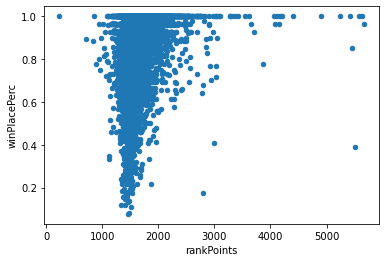

In [53]:
trainv2[(trainv2.killPlace==1)&(trainv2.rankPoints>0)].loc[:,['killPlace','rankPoints','winPlacePerc']].plot.scatter(x='rankPoints',y='winPlacePerc')

In [54]:
trainv2['Points']=trainv2.loc[:,['killPoints','winPoints']].sum(axis=1)
trainv2[trainv2.damageDealt>3000].loc[:,['matchId','killPlace','killPoints','winPoints','rankPoints','Points','winPlacePerc']].sort_values(by='Points')

,matchId,killPlace,killPoints,winPoints,rankPoints,Points,winPlacePerc
3399193,2cf69d2fe25759,1,0,0,1500,0,1.0000
4137398,2434397d3cc0a8,1,0,0,1738,0,1.0000
118502,780e8216d0405a,1,1000,1500,-1,2500,0.9583
2408790,d70739f1dfa5e5,1,1000,1500,-1,2500,1.0000
2576525,2ff706a52ad9cc,1,1000,1500,-1,2500,1.0000
3907723,12d2b7e562a2bd,1,1052,1502,-1,2554,0.8462
1894726,e5ee20f917abe1,1,1221,1517,-1,2738,1.0000
2024917,8912f6c2a9853a,1,1305,1511,-1,2816,1.0000
1493308,4f8be30d0cadeb,1,1345,1534,-1,2879,0.8800
3840888,59e23ee8543fd2,1,1613,1515,-1,3128,1.0000


In [ ]:
trainv2[trainv2.matchId=='780e8216d0405a'].loc[:,['matchId','kills','killPlace','killPoints','winPoints','rankPoints','Points','winPlacePerc']].sort_values(by='killPlace')

In [ ]:
#kill이 없음에도 killpoint가 있으며 킬포인트와 윈포인트를 합한 수치가 타겟값과 비례관계로 보여지지도 않으며
#killpoint와 winpoint는 우리가 알지 못하는 id 값에 대한 계산 수치가(elo) 따로 있는것으로 판단되어지고
#결론적으로 point 컬럼들을 모델학습에 활용하는것이 좋은지 안좋은지 판단 불가

In [ ]:
#데미지는 중요데이터 이므로 이상치 확인해야됨
sns.jointplot(data=df,x='damageDealt',y='winPlacePerc')

In [ ]:
#데이터가 깔끔해 보이며 3000딜량 이상만 확인해봐야겠다
df[df.damageDealt>3000]#이상치는 없어 보인다

In [34]:
############################################################################################################################


In [50]:
df[df.headshotKills>=df.kills].loc[:,['matchId']]
df[df.matchId=='bac52627a12114'].loc[:,['kills','headshotKills']].sort_values(by='kills',ascending=False).head(10)

,kills,headshotKills
3816996,7,1
3552908,6,2
764527,5,2
443399,4,1
2858036,3,1
2073631,3,0
2347470,3,1
732188,3,0
602973,3,0
4205034,3,1


In [51]:
trainv2['headKills']=trainv2['headshotKills']/trainv2['kills']
trainv2.headKills.fillna(0,inplace=True)
trainv2.headKills.value_counts()

0.000000    3651704
1.000000     251787
0.500000     193969
0.333333     102541
0.250000      52437
             ...   
0.052632          1
0.217391          1
0.653846          1
0.904762          1
0.421053          1
Name: headKills, Length: 143, dtype: int64

In [55]:
trainv2['healing'] = trainv2['boosts']+trainv2['heals']

In [59]:
trainv2['groupcnt']=trainv2.groupby('groupId').groupId.transform('count')

In [69]:
trainv2["plus"]=trainv2.loc[:,['walkDistance','rideDistance']].sum(axis=1).round(2)

In [77]:
trainv2["time_gun"]=(trainv2['walkDistance']/trainv2['weaponsAcquired']).round(2)

In [80]:
trainv2['time_kills']=trainv2['walkDistance']/trainv2['kills']

In [85]:
trainv2.time_kills.replace(np.inf, 0,inplace=True)

In [110]:
trainv2['team']=trainv2['assists']+trainv2['revives']


In [116]:
df.describe(include=['O'])
drop_col =['Id','groupId','matchId','matchType','killPlace','winPlacePerc']
features =[col for col in df.columns if col not in drop_col]
agg_mean = df.groupby(['matchId','groupId'])[features].mean()
agg_rank = agg_mean.groupby('matchId')[features].rank(pct=True)
df=df.merge(agg_rank,suffixes=['','_rank'],how='left',on=['matchId','groupId'])

In [119]:
df.shape,ddf.shape

((4390578, 52), (4390578, 29))

In [105]:
features=['assists','boosts']

In [108]:
agg=ddf.groupby(['matchId', 'groupId'])[features].mean()

In [109]:
ddf.merge(agg, suffixes=['', '_mean'], how='left', on=['matchId', 'groupId'])

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,assists_mean,boosts_mean
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.000,0,0,244.80,1,1466,0.4444,0.00,0.000000
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,11.040,0,0,1434.00,5,0,0.6400,0.50,1.500000
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.000,0,0,161.80,2,0,0.7755,0.50,1.500000
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.000,0,0,202.70,3,0,0.1667,0.00,0.000000
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.000,0,0,49.75,2,0,0.1875,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4390573,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,0.000,0,0,1019.00,3,1507,0.1786,0.00,0.400000
4390574,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0,0.000,0,0,81.70,6,0,0.2935,0.00,1.000000
4390575,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,2.184,0,0,788.70,4,0,0.4815,0.00,0.333333
4390576,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,0,0.000,0,0,2748.00,8,0,0.8000,0.25,2.250000


In [ ]:
#참여그룹수 참여인원수 대비 매치시간이 걸은거리와 차량이동에 영향을 미치어 학습되어 질수 있다 판단되어져 사용해야될꺼라 판단
#힐과 부스트또한 중요지표라 판단되어지며 합치거나 이상치 제거를 해야된다고 판단
#어시스트와 리바이스는 솔로인 경우 데이터가 없어 제거하기로함 
#차량킬과 탈것파괴또한 drop 등수와 크게 연관이 없다고 판단
#아..AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

In [ ]:
#lightbgm

In [120]:
drop_col =['Id','groupId','matchId','matchType','killPlace','winPlacePerc']
features =[col for col in df.columns if col not in drop_col]
X =df[features]
y= df['winPlacePerc']

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=24,test_size=0.2)
model = LGBMRegressor(n_estimators=400)
model.fit(X_train,y_train)
preds = model.predict(X_test)
print("MAE : %.4f" % mean_absolute_error(y_test,preds)) 
#matchtype : 0.0889 
# 0.0885
# 0.0885
# 0.0863
# 0.0862
# 0.0862
# 0.0862
# 0.0862


MAE : 0.0576


In [57]:
feature = ['assists',
           'boosts',
           'damageDealt',
           'DBNOs',           
           'headshotKills',
           'heals',
           'killPoints',
           'kills',
           'killStreaks', 
           'longestKill', 
           'matchDuration',
           'maxPlace',           
           'numGroups', 
           'rankPoints',
           'revives', 
           'rideDistance', 
           'roadKills',           
           'swimDistance',
           'teamKills',
           'vehicleDestroys',
           'walkDistance',
           'weaponsAcquired',
           'winPoints',
           'matchtype',
           'headKills',
           'healing',
           'groupcnt',
           'plus',
           'time_gun',
           'time_kills',
           'team'
          ]
X =trainv2[feature]
y= trainv2['winPlacePerc']

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=24,test_size=0.2)
model = LGBMRegressor(n_estimators=400)
model.fit(X_train,y_train)
preds = model.predict(X_test)
print("MAE : %.4f" % mean_absolute_error(y_test,preds)) 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

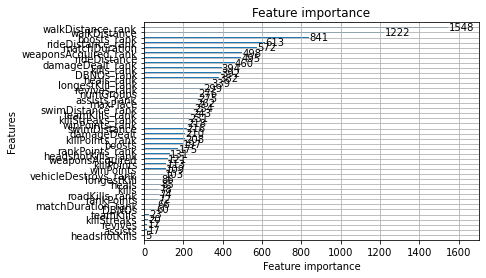

In [121]:
plot_importance(model)

In [ ]:
##전투 damageDealt,kills(headshotKills),assists,DBNOs
##이동 walkDistance,rideDistance
##생존 heals/boosts revives

In [20]:
feature = ['damageDealt',
           'kills',
           'headshotKills',
           'assists',
           'DBNOs',
           'walkDistance',
           'rideDistance', 
           'heals',
           'boosts',
           'revives'           
          ]
X =trainv2[feature]
y= trainv2['winPlacePerc']
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=24,test_size=0.2)
model = LGBMRegressor(n_estimators=400)
model.fit(X_train,y_train)
preds = model.predict(X_test)
print("MAE : %.4f" % mean_absolute_error(y_test,preds))

MAE : 0.1032


In [10]:
feature = ['kills',
'headshotKills',
'DBNOs',
'damageDealt',
'walkDistance',
'rideDistance',
'killPoints',
'winPoints',
'rankPoints',
'heals',
'boosts'  
]
X =trainv2[feature]
y= trainv2['winPlacePerc']
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=24,test_size=0.2)
model = LGBMRegressor(n_estimators=400)
model.fit(X_train,y_train)
preds = model.predict(X_test)
print("MAE : %.4f" % mean_absolute_error(y_test,preds))

MAE : 0.1021


In [22]:
feature = ['boosts',
           'damageDealt',
           'heals',
           'kills',
           'walkDistance',
           'weaponsAcquired',
           'matchDuration',
           'rideDistance',
           'maxPlace',
           'numGroups',
           'rankPoints',
           'swimDistance'
]
X =trainv2[feature]
y= trainv2['winPlacePerc']
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=24,test_size=0.2)
model = LGBMRegressor(n_estimators=400)
model.fit(X_train,y_train)
preds = model.predict(X_test)
print("MAE : %.4f" % mean_absolute_error(y_test,preds))

MAE : 0.0899


In [124]:
df[df.rankPoints!=-1].loc[:,['killPoints','winPoints','rankPoints']]

,killPoints,winPoints,rankPoints
1,0,0,1484
2,0,0,1491
3,0,0,1408
4,0,0,1560
5,0,0,1418
...,...,...,...
4390572,0,0,1477
4390574,0,0,1501
4390575,0,0,1500
4390576,0,0,1418


,killPoints,winPoints,rankPoints
